# ReRun with I.C.

In [1]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numba as nb
from numba import jit
import os
from sklearn.cluster import KMeans
import pickle
import pyfftw
from sklearn.cluster import MiniBatchKMeans
import psutil
process = psutil.Process(os.getpid())

In [2]:
def readData(fileName):
    dt = np.dtype([('header', '33c'), ('wf', '3500h')])
    s = os.stat(fileName)
    N = int((s.st_size - 8)/7033)
    with open(fileName, 'rb') as file:
        theader = np.core.records.fromfile(file,formats='Q',shape=1,byteorder='<')[0][0]
        file.seek(8)
        data = np.core.records.fromfile(file, dtype=dt ,shape=N,byteorder='<')
    return data

In [3]:
def bitLogic(data):
    # make bitlogic function and compile it to c code
    @jit(nopython=True)
    def bitLogic(x):
        for i in range(3500):
            x[i] &= 16383
            if x[i]>8191:
                x[i] -= 16384
    bitLogic(np.arange(3500, dtype='h'))
    # run over the data
    for j in range(len(data)):
        bitLogic(data['wf'][j])

In [4]:
def getPixelInfo(data):
    dh = np.dtype([
        ('result',np.ubyte), ('event id', 'i'), 
        ('board number', 'i4'), ('channel number', 'i4'),
        ('req. timestamp',np.uint64), ('cur timestamp',np.uint64),
        ('length', 'i4')])

    buf = data['header'].copy(order='C')

    headerInfo = buf.view(dh)

    headerInfo

    # lookup table as described in image
    pixel_to_bc = { '39W':(0,1),'62W':(1,1),'77W':(2,1),'39E':(3,1),'62E':(4,1),'77E':(5,1), \
                    '40W':(0,2),'63W':(1,2),'78W':(2,2),'40E':(3,2),'63E':(4,2),'78E':(5,2), \
                    '41W':(0,3),'64W':(1,3),'87W':(2,3),'41E':(3,3),'64E':(4,3),'87E':(5,3), \
                    '50W':(0,4),'65W':(1,4),'88W':(2,4),'50E':(3,4),'65E':(4,4),'88E':(5,4), \
                    '51W':(0,5),'66W':(1,5),'89W':(2,5),'51E':(3,5),'66E':(4,5),'89E':(5,5), \
                    '52W':(0,6),'75W':(1,6),            '52E':(3,6),'75E':(4,6),       \
                    '53W':(0,7),'76W':(1,7),            '53E':(3,7),'76E':(4,7) }

    bc_to_pixel = {}
    for x in pixel_to_bc.items():
        bc_to_pixel[x[1]] = x[0]

    pixel_to_bc['51W']

    bc_to_pixel[(0,5)]

    pixelIDs = []

    for i in range(len(headerInfo)):
        x = (headerInfo[i]['board number'][0], headerInfo[i]['channel number'][0])
        if x in bc_to_pixel:
            pixelIDs.append(bc_to_pixel[x])
        else:
            pixelIDs.append('NA_')
    return pixelIDs

In [5]:
# fall_times[board][channel] 
fall_times=[[1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000,      1230.2096, 1188.8999],\
            [1000, 1263.1642, 1233.1743, 999.1461,  1199.1291, 1112.0769, 1049.4534, 1219.0482],\
            [1000, 1000,      1077.4932, 1157.1627, 1000,      1163.2235, 1000,      1000],\
            [1000, 1027.103,  1111.1212, 1033.5468, 1109.469,  1022.693,  1929.7336, 1000],\
            [1000, 1124.478,  1073.1306, 1007.7979, 1100.4457, 1045.0566, 1135.8975, 1073.1854],\
            [1000, 1000,      1087.187,  1133.1069, 1005.3494, 1000,      1000,      1000]]

# lookup table as described in image
pixel_to_bc = { '39W':(0,1),'62W':(1,1),'77W':(2,1),'39E':(3,1),'62E':(4,1),'77E':(5,1), \
                '40W':(0,2),'63W':(1,2),'78W':(2,2),'40E':(3,2),'63E':(4,2),'78E':(5,2), \
                '41W':(0,3),'64W':(1,3),'87W':(2,3),'41E':(3,3),'64E':(4,3),'87E':(5,3), \
                '50W':(0,4),'65W':(1,4),'88W':(2,4),'50E':(3,4),'65E':(4,4),'88E':(5,4), \
                '51W':(0,5),'66W':(1,5),'89W':(2,5),'51E':(3,5),'66E':(4,5),'89E':(5,5), \
                '52W':(0,6),'75W':(1,6),            '52E':(3,6),'75E':(4,6),       \
                '53W':(0,7),'76W':(1,7),            '53E':(3,7),'76E':(4,7) }

# put it all together to look up fall time
def fallTimeLookup(pixel):
    if (pixel not in pixel_to_bc):
        #print('Could not find pixel '+pixel+' in lookup table')
        return None
    board, channel = pixel_to_bc[pixel]
    return fall_times[board][channel]

In [6]:
@jit(nopython=True)
def rc2_cr(wf, fallTime):
    wf2 = np.empty(3500)
    length = len(wf2)
    wf -= np.mean(wf[:400])
    
    alpha_cr = fallTime/(fallTime+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;    
    zrc1 = np.zeros(2)
    zcr = np.zeros(2)
    zcharge = np.zeros(2)
    zrc2 = wf[:2].copy()
    for i in range(length):
        zrc2[i%2] = wf[i]
        
        zrc1[i%2] = (zrc2[i%2] - zrc2[(i+1)%2])/alpha_rc2 + zrc2[(i+1)%2]
        zcr[i%2] = (zrc1[i%2] - zrc1[(i+1)%2])/alpha_rc1 + zrc1[(i+1)%2]
        zcharge[i%2] = (zcr[i%2]/alpha_cr) - zcr[(i+1)%2] + zcharge[(i+1)%2] 

        wf2[i] = zcharge[i%2]
    
    return wf2/np.mean(wf2[-1000:])

In [1]:
@jit(nopython=True)
def normBatch(x):
    for i in range(len(x)):
        x[i] = x[i] - np.amin(x[i])
        x[i] = x[i]*2./np.amax(x[i])
        x[i] = x[i] - 1
    return x

NameError: name 'jit' is not defined

In [8]:
import pyfftw

In [9]:
def amplitudes(data):
    ## Get trapezoid filter
    tau = np.int(1000)
    rise = np.int(200)
    top = np.int(100)
    trap = np.empty(3500)
    for i in range(rise):
        trap[i] = tau + i
        trap[i+rise+top] = rise - tau - i
    for i in range(rise, rise+top):
        trap[i] = rise
    for i in range(rise+top, 3500):
        trap[i] = 0
    trap = trap/(rise*tau)
    trap[rise+top:2*rise+top] = -trap[:rise]
    trapNew = np.fft.rfft(trap)

    # Get amplitudes
    f = pyfftw.interfaces.numpy_fft.irfft(pyfftw.interfaces.numpy_fft.rfft(data)*trapNew)
    E = np.amax(f, 1, keepdims=True)
    E -= np.mean(f[:,:100], 1, keepdims=True)
    return E

In [11]:
def LoadData(fileName):
    """
    Fancy Version - applies inverse shaping filter
    Read in a calcium 45 file and predicts with k means clustering
    Returns: X(normalized), E(approx), pixelIDs, predicted Label(with 'kmean_ic')
    """
    data = readData(fileName)
    bitLogic(data)
    pixelIDs = getPixelInfo(data)
    
    X = np.empty((len(data), len(data['wf'][0])))

    E = np.array([amplitudes(data['wf'][i*10**4:(i+1)*10**4].astype(np.float32)) for i in range(40)]).flatten()
    E = np.append(E, amplitudes(data['wf'][40*10**4:].astype(np.float32)))
    
    for i in range(len(X)):
        tau = fallTimeLookup(pixelIDs[i])
        if tau==None:
            X[i] = data['wf'][i].astype(np.float32)
        else:
            X[i] = rc2_cr(data['wf'][i].astype(np.float32), tau)
            
    #X[:10] = normBatch(X[:10])
    #X = normBatch(X)

    return X, E

In [12]:
X, E = LoadData('Run_00120_00.bin')

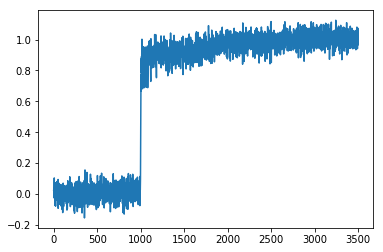

In [13]:
plot(X[-2000])

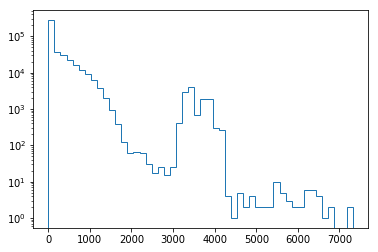

In [14]:
hist(E, histtype='step', bins=50);
yscale('log')

In [21]:
with open('kmean_ic0', 'rb') as file:
    kmean = pickle.load(file)

In [16]:
#kmean = KMeans(n_clusters=11, n_jobs=2)

In [17]:
#kmean.fit(X[:10**5])

In [18]:
with open('kmean_ic0', 'wb') as file:
    pickle.dump(kmean, file)

In [1]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [3]:
kmean = KMeans(n_clusters=20, n_init=200)

In [36]:
kmean.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=20, n_init=200, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [22]:
kmean.predict(X)

array([1, 3, 1, ..., 5, 5, 9], dtype=int32)

In [23]:
weird_ones = [3, 2, 0, 11, 14, 16, 5, 7, 12, 6, 10]

In [121]:
kmean.labels_ = kmean.predict(X)

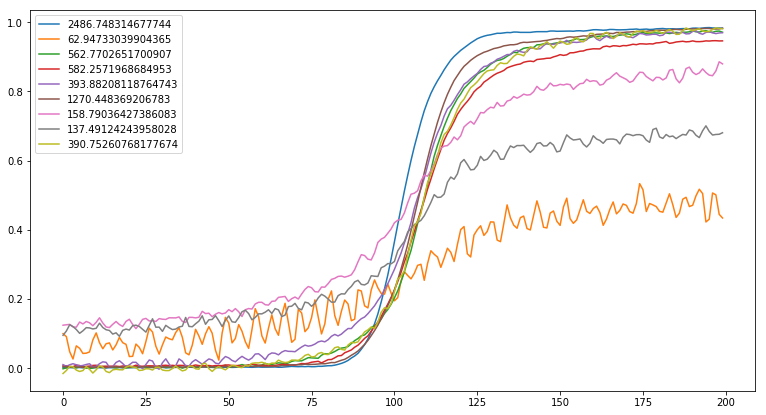

In [130]:
f = plt.figure(figsize=(13,7))
for i in range(len(kmean.cluster_centers_)):
    if i not in weird_ones:
        x = kmean.cluster_centers_[i] - np.mean(kmean.cluster_centers_[i][:500])
        plt.plot((x/np.amax(x))[900:1100], label=str(np.mean([E[j] for j in range(len(X)) if kmean.labels_[j]==i])))
plt.legend()

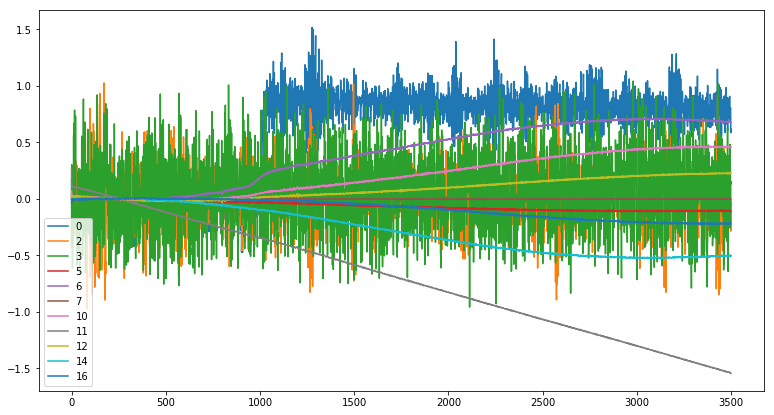

In [84]:
f = plt.figure(figsize=(13,7))
for i in range(len(kmean.cluster_centers_)):
    if i in weird_ones:
        plt.plot(kmean.cluster_centers_[i] - np.mean(kmean.cluster_centers_[i][:500]), label=str(i))
plt.legend()

In [146]:
E_range = np.linspace(200,6200,61)
WF = [[] for i in range(len(E_range))]
WF_COUNT = np.zeros(len(E_range))
E_range

array([ 200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
       1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900.,
       2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800.,
       2900., 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700.,
       3800., 3900., 4000., 4100., 4200., 4300., 4400., 4500., 4600.,
       4700., 4800., 4900., 5000., 5100., 5200., 5300., 5400., 5500.,
       5600., 5700., 5800., 5900., 6000., 6100., 6200.])

In [148]:
for i, x in enumerate(X):
    if E[i] > E_range[-1]:
        pass
    elif E[i] <= E_range[0]:
        pass
    else:
        index = np.where((E_range<E[i])*(E_range+100>=E[i]))[0][0]
        WF[index].append(x)
        WF_COUNT[index] += 1

In [149]:
WF_COUNT

array([2.4720e+04, 2.1220e+04, 1.7430e+04, 1.4153e+04, 1.1387e+04,
       9.0730e+03, 7.5210e+03, 6.1580e+03, 5.0290e+03, 3.6380e+03,
       2.4120e+03, 1.6380e+03, 1.0520e+03, 5.5800e+02, 3.2900e+02,
       1.2900e+02, 7.6000e+01, 3.8000e+01, 4.8000e+01, 4.6000e+01,
       4.0000e+01, 3.5000e+01, 1.3000e+01, 1.3000e+01, 1.8000e+01,
       1.5000e+01, 1.0000e+01, 1.5000e+01, 1.6000e+01, 2.3400e+02,
       2.1190e+03, 2.1910e+03, 2.7580e+03, 5.8300e+02, 6.9900e+02,
       1.3580e+03, 1.5460e+03, 5.7200e+02, 1.1400e+02, 2.4800e+02,
       3.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00,
       1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
       2.0000e+00, 1.0000e+00, 4.0000e+00, 7.0000e+00, 3.0000e+00,
       3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
       0.0000e+00])

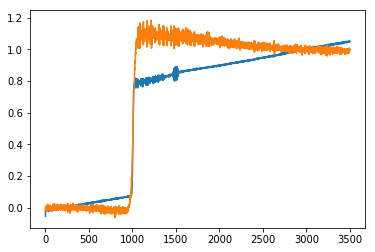

In [154]:
plot(np.mean(WF[12], 0))
plot(np.mean(WF[0], 0))